# Noise2Self-inspired Optopatch denoising

In [1]:
%matplotlib inline

import os
import sys
notebook_path = os.path.abspath('.')
sources_path = os.path.abspath(os.path.join(notebook_path, '..'))
sys.path.insert(0, sources_path)

import matplotlib.pylab as plt
import numpy as np
from time import time
import torch
import logging
import json
import pprint
import pickle

from typing import List

from cellmincer.opto_ws import OptopatchBaseWorkspace, OptopatchDenoisingWorkspace

from cellmincer.opto_features import OptopatchGlobalFeatureContainer

from cellmincer.opto_utils import \
    crop_center, \
    get_nn_spatio_temporal_mean, \
    get_nn_spatial_mean

from cellmincer.opto_denoise import \
    get_minimum_spatial_padding, \
    generate_occluded_training_data, \
    get_noise2self_loss, \
    generate_input_for_single_frame_denoising, \
    denoise_single_frame

from cellmincer.opto_models import \
    ConditionalUNet, \
    TemporalDenoiser, \
    activation_from_str


device = torch.device("cuda")
dtype = torch.float32

def new_fig(figsize=(15, 5)):
    fig = plt.figure(figsize=figsize)
    ax = plt.gca()
    return fig, ax

logger = logging.getLogger()

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

In [2]:
from contextlib import contextmanager

@contextmanager
def evaluating(net):
    '''Temporarily switch to evaluation mode.'''
    istrain = net.training
    try:
        net.eval()
        yield net
    finally:
        if istrain:
            net.train()
    
###############################################################################################
# TODO
# this method needs major improvement
# currently, to denoise each frame, `t_order` frames are processed
# this leads to significant redundancy in calculations since in principle,
# the U-Net needs to operate on every frame only once
#
# the better implementation must first process each frame with `spatial_unet_processor`,
# perhaps in large batches and keep the results in GPU memory. then we run `temporal_denoiser`
# on rolling windows.
###############################################################################################

def generate_denoised_movie(
        ws_denoising_list: List[OptopatchBaseWorkspace],
        spatial_unet_processor: List[OptopatchDenoisingWorkspace],
        temporal_denoiser: torch.nn.Module,
        i_dataset: int,
        i_t_begin: int,
        i_t_end: int,
        x0: int,
        y0: int,
        x_window: int,
        y_window: int):
    

    denoised_movie_txy = np.zeros(
        (i_t_end - i_t_begin, ws_denoising_list[0].width, ws_denoising_list[0].height),
        dtype=np.float32)

    with evaluating(spatial_unet_processor):
        with evaluating(temporal_denoiser):
            
            for i_t in range(i_t_begin, i_t_end):

                denoising_input_data = generate_input_for_single_frame_denoising(
                    ws_denoising_list=ws_denoising_list,
                    i_dataset=i_dataset,
                    i_t=i_t,
                    t_order=denoiser_config['t_order'],
                    x0=x0,
                    y0=y0,
                    x_window=x_window,
                    y_window=y_window,
                    device=device,
                    dtype=dtype)

                output = denoise_single_frame(
                    denoising_input_data,
                    ws_denoising_list=ws_denoising_list,
                    spatial_unet_processor=spatial_unet_processor,
                    temporal_denoiser=temporal_denoiser)                
                temporal_endpoint_xy = output['temporal_endpoint_xy']

                denoised_movie_txy[
                    i_t - i_t_begin,
                    x0:(x0 + x_window),
                    y0:(y0 + y_window)] = temporal_endpoint_xy.cpu().numpy()

        return denoised_movie_txy


def get_denoised_movie_sma_txy(denoised_movie_txy_list):
    n_movies = len(denoised_movie_txy_list)
    denoised_movie_sma_txy = denoised_movie_txy_list[0].copy() / n_movies
    for denoised_movie_txy in denoised_movie_txy_list[1:]:
        denoised_movie_sma_txy += (denoised_movie_txy / n_movies)
    return denoised_movie_sma_txy


def save_model_state(model_root, model_prefix, index, save_adam_state=True):
    full_model_prefix = f'{model_prefix}__{index:06d}'
    with open(os.path.join(model_root, f'denoiser_config__{full_model_prefix}.json'), 'w') as f:
        json.dump(denoiser_config, f)
    torch.save(
        spatial_unet_processor.state_dict(),
        os.path.join(model_root, f'spatial_unet_processor__{full_model_prefix}.pt'))
    torch.save(
        temporal_denoiser.state_dict(),
        os.path.join(model_root, f'temporal_denoiser__{full_model_prefix}.pt'))
    if save_adam_state:
        torch.save(
            optim.state_dict(),
            os.path.join(model_root, f'adam_state__{full_model_prefix}.pt'))


def load_model_state(model_root, model_prefix, index):
    spatial_unet_processor_state = \
        torch.load(os.path.join(
            model_root, f'spatial_unet_processor__{model_prefix}__{index:06d}.pt'))
    temporal_denoiser_state = \
        torch.load(os.path.join(
            model_root, f'temporal_denoiser__{model_prefix}__{index:06d}.pt'))
    try:
        adam_state = torch.load(os.path.join(
            model_root, f'adam_state__{model_prefix}__{index:06d}.pt'))
    except:
        adam_state = None
    return {
        'spatial_unet_processor_state': spatial_unet_processor_state,
        'temporal_denoiser_state': temporal_denoiser_state,
        'adam_state': adam_state}


def get_swa_state_dict(model_root, model_prefix, begin_index, end_index):
    first_state = load_model_state(model_root, model_prefix, begin_index)
    keys = list(first_state.keys())

    ave_state = first_state
    n_summed = 1
    for index in range(begin_index + 1, end_index):
        try:
            c_state = load_model_state(model_root, model_prefix, index)
        except:
            continue
            
        for key in keys:
            ave_state[key] += c_state[key]

        n_summed += 1

    for key in keys:
        ave_state[key] /= n_summed
        
    return ave_state


def smooth_list(values, smoothing_window):
    if len(values) < smoothing_window:
        return np.mean(values)
    else:
        return np.mean(values[-smoothing_window:])

## Configuration

In [3]:
opto_mov_prefixes = [
    'test_data',
]

opto_diff_mov_path_list = [
    f'/home/jupyter/mb-ml-data/Optosynth_output/test_data_proc/{prefix}_trend_subtracted.npy'
    for prefix in opto_mov_prefixes
]

opto_bg_mov_path_list = [
    f'/home/jupyter/mb-ml-data/Optosynth_output/test_data_proc/{prefix}_trend.npy'
    for prefix in opto_mov_prefixes
]

opto_noise_params_path_list = [
    f'/home/jupyter/mb-ml-data/Optosynth_output/test_data_proc/{prefix}_noise_params.json'
    for prefix in opto_mov_prefixes
]

opto_feature_path_list = [
    f'/home/jupyter/mb-ml-data/Optosynth_output/test_data_proc/{prefix}__features.pkl'
    for prefix in opto_mov_prefixes
]


# output
output_path = '/home/jupyter/mb-ml-data/Optosynth_output/test_data_proc'
model_root = '/home/jupyter/mb-ml-data/Optosynth_output/test_data_proc'

if not os.path.exists(output_path):
    os.mkdir(output_path)
    
if not os.path.exists(model_root):
    os.mkdir(model_root)

### Model config

In [4]:
model_prefix = 'test'
denoiser_config_path = os.path.join(model_root, f'denoiser_config__{model_prefix}__000001.json')
denoiser_config_path = None

if denoiser_config_path is None:
    
    # this configuration requires 16gb of GPU memory (e.g. Tesla V100)
    denoiser_config = {
        'occlusion_prob': 0.05,
        'occlusion_radius': 0,
        'occlusion_strategy': 'random',
        'spatial_unet_padding': True,
        'spatial_unet_depth': 3,
        'spatial_unet_wf': 5,
        'spatial_unet_n_conv_layers': 3,
        'spatial_unet_out_channels_before_readout': 32,
        'spatial_unet_readout_hidden_layer_channels_list': [],
        'spatial_unet_readout_kernel_size': 1,
        'spatial_unet_kernel_size': 3,
        'spatial_unet_activation': 'relu',
        'spatial_unet_batch_norm': False,
        'temporal_denoiser_n_conv_layers': 3,
        'temporal_denoiser_kernel_size': 5,
        'temporal_denoiser_conv_channels': 32,
        'temporal_denoiser_hidden_dense_layer_dims': [32, 32],
        'temporal_denoiser_activation': 'relu'
    }
    
    t_order = (1 +
               (denoiser_config['temporal_denoiser_kernel_size'] - 1) *
               (denoiser_config['temporal_denoiser_n_conv_layers']))
    denoiser_config['t_order'] = t_order
    
else:
    
    logging.warning(f'Loading denoising model configuration from {denoiser_config_path} ...')
    
    with open(denoiser_config_path, 'r') as f:
        denoiser_config = json.load(f)

pprint.pprint(denoiser_config)

{'occlusion_prob': 0.05,
 'occlusion_radius': 0,
 'occlusion_strategy': 'random',
 'spatial_unet_activation': 'relu',
 'spatial_unet_batch_norm': False,
 'spatial_unet_depth': 3,
 'spatial_unet_kernel_size': 3,
 'spatial_unet_n_conv_layers': 3,
 'spatial_unet_out_channels_before_readout': 32,
 'spatial_unet_padding': True,
 'spatial_unet_readout_hidden_layer_channels_list': [],
 'spatial_unet_readout_kernel_size': 1,
 'spatial_unet_wf': 5,
 't_order': 13,
 'temporal_denoiser_activation': 'relu',
 'temporal_denoiser_conv_channels': 32,
 'temporal_denoiser_hidden_dense_layer_dims': [32, 32],
 'temporal_denoiser_kernel_size': 5,
 'temporal_denoiser_n_conv_layers': 3}


In [5]:
training_x_window = 96
training_y_window = 96

x_padding, y_padding = get_minimum_spatial_padding(
    x_window=training_x_window,
    y_window=training_y_window,
    denoiser_config=denoiser_config)

print(f'x-padding: {x_padding}px')
print(f'y-padding: {y_padding}px')

x-padding: 0px
y-padding: 0px


## Load datasets

In [6]:
# setup datasets
ws_base_diff_list = []
ws_base_bg_list = []
feature_container_list = []
noise_params_list = []

for (opto_diff_mov_path,
     opto_bg_mov_path,
     opto_noise_params_path,
     opto_feature_path) in zip(
        opto_diff_mov_path_list,
        opto_bg_mov_path_list,
        opto_noise_params_path_list,
        opto_feature_path_list):
    ws_base_diff = OptopatchBaseWorkspace.from_npy(opto_diff_mov_path)
    ws_base_bg = OptopatchBaseWorkspace.from_npy(opto_bg_mov_path)
    with open(opto_noise_params_path, 'r') as f:
        noise_params = json.load(f)
    with open(opto_feature_path, 'rb') as f:
        feature_container = pickle.Unpickler(f).load()
    
    ws_base_diff_list.append(ws_base_diff)
    ws_base_bg_list.append(ws_base_bg)
    noise_params_list.append(noise_params)
    feature_container_list.append(feature_container)
    
n_datasets = len(ws_base_diff_list)

ws_denoising_list = []
for i_dataset in range(n_datasets):
    ws_denoising = OptopatchDenoisingWorkspace(
        ws_base_diff=ws_base_diff_list[i_dataset],
        ws_base_bg=ws_base_bg_list[i_dataset],
        noise_params=noise_params_list[i_dataset],
        features=feature_container_list[i_dataset],
        x_padding=x_padding,
        y_padding=y_padding,
        device=device,
        dtype=dtype)
    ws_denoising_list.append(ws_denoising)

Loading movie from /home/jupyter/mb-ml-data/Optosynth_output/test_data_proc/test_data_trend_subtracted.npy ...
Loading movie from /home/jupyter/mb-ml-data/Optosynth_output/test_data_proc/test_data_trend.npy ...


## Instantiate the denoising model

In [7]:
spatial_unet_processor = ConditionalUNet(
    in_channels=1,
    out_channels=1,
    data_dim=2,
    feature_channels=ws_denoising_list[0].n_global_features,
    depth=denoiser_config['spatial_unet_depth'],
    wf=denoiser_config['spatial_unet_wf'],
    out_channels_before_readout=denoiser_config['spatial_unet_out_channels_before_readout'],
    pad=denoiser_config['spatial_unet_padding'],
    batch_norm=denoiser_config['spatial_unet_batch_norm'],
    unet_kernel_size=denoiser_config['spatial_unet_kernel_size'],
    n_conv_layers=denoiser_config['spatial_unet_n_conv_layers'],
    readout_kernel_size=denoiser_config['spatial_unet_readout_kernel_size'],
    readout_hidden_layer_channels_list=denoiser_config['spatial_unet_readout_hidden_layer_channels_list'],
    activation=activation_from_str(denoiser_config['spatial_unet_activation']),
    final_trans=torch.nn.Identity(),
    device=device,
    dtype=dtype)

temporal_denoiser = TemporalDenoiser(
    in_channels=denoiser_config['spatial_unet_out_channels_before_readout'],
    feature_channels=ws_denoising_list[0].n_global_features,
    t_order=denoiser_config['t_order'],
    kernel_size=denoiser_config['temporal_denoiser_kernel_size'],
    hidden_conv_channels=denoiser_config['temporal_denoiser_conv_channels'],
    hidden_dense_layer_dims=denoiser_config['temporal_denoiser_hidden_dense_layer_dims'],
    activation=activation_from_str(denoiser_config['temporal_denoiser_activation']),
    final_trans=torch.nn.Identity(),
    device=device,
    dtype=dtype)

In [8]:
spatial_unet_processor

ConditionalUNet(
  (down_path): ModuleList(
    (0): UNetConvBlock(
      (block): Sequential(
        (0): Conv2d(75, 32, kernel_size=(3, 3), stride=(1, 1))
        (1): ReLU()
        (2): ReflectionPad2d((1, 1, 1, 1))
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
        (4): ReLU()
        (5): ReflectionPad2d((1, 1, 1, 1))
        (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
        (7): ReLU()
        (8): ReflectionPad2d((1, 1, 1, 1))
      )
    )
    (1): UNetConvBlock(
      (block): Sequential(
        (0): Conv2d(106, 64, kernel_size=(3, 3), stride=(1, 1))
        (1): ReLU()
        (2): ReflectionPad2d((1, 1, 1, 1))
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (4): ReLU()
        (5): ReflectionPad2d((1, 1, 1, 1))
        (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (7): ReLU()
        (8): ReflectionPad2d((1, 1, 1, 1))
      )
    )
    (2): UNetConvBlock(
      (block): Sequential(
        (0): Conv2

In [9]:
temporal_denoiser

TemporalDenoiser(
  (conv_block): Sequential(
    (0): Conv3d(32, 32, kernel_size=(5, 1, 1), stride=(1, 1, 1))
    (1): ReLU()
    (2): Conv3d(32, 32, kernel_size=(5, 1, 1), stride=(1, 1, 1))
    (3): ReLU()
    (4): Conv3d(32, 32, kernel_size=(5, 1, 1), stride=(1, 1, 1))
    (5): ReLU()
  )
  (dense_block): Sequential(
    (0): Conv3d(32, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (1): ReLU()
    (2): Conv3d(32, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (3): ReLU()
    (4): Conv3d(32, 1, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  )
  (final_trans): Identity()
)

In [10]:
all_params = (
    list(spatial_unet_processor.parameters()) +
    list(temporal_denoiser.parameters()))

optim = torch.optim.Adam(all_params, lr=1e-4, betas=(0.9, 0.999))

## Load a pre-trained model

In [12]:
load_model = False
model_prefix_to_load = 'rc1_synth'
model_index = 0

if load_model:
    logging.warning(f'Loading a pre-trained model ...')
    loaded_state_dict = load_model_state('/home/jupyter/mb-ml-dev-disk/Optosynth/test_synth_data', 'optosynth_test_movie', model_index)
    
    spatial_unet_processor.load_state_dict(loaded_state_dict['spatial_unet_processor_state'])
    temporal_denoiser.load_state_dict(loaded_state_dict['temporal_denoiser_state'])
    if loaded_state_dict['adam_state'] is not None:
        optim.load_state_dict(loaded_state_dict['adam_state'])

In [13]:
# change the model prefix to continue as a new model
model_prefix = 'rc1_synth'

## Train on the loaded datasets

In [14]:
total_loss_hist = []
unet_rec_loss_hist = []
unet_reg_loss_hist = []
temporal_rec_loss_hist = []
temporal_reg_loss_hist = []
denoised_movie_hist = []

In [15]:
# save results?
enable_save = True

# loss and minibatching config
n_loop = 1
n_batch_per_loop = 20
n_batch = n_loop * n_batch_per_loop

t_tandem = 0
norm_p = 1
loss_type = 'poisson_gaussian'
wd = 0.1
unet_admixing = 0.0

# regularization config
enable_continuity_reg = False
continuity_reg_strength = 1.0
noise_threshold_to_std = 0.05
reg_func = 'clamped_linear'

# training tracking config
n_iters = 50_001
log_every = 10
denoise_every = np.inf
save_every = 5000
smoothing_window = 500

# only if sampling denoised movie is required (denoise_every != np.inf)
i_dataset_denoising = 0
i_t_begin_denoising = 50
i_t_end_denoising = 600
x0_denoising = 0
y0_denoising = 0
x_window_denoising = 512
y_window_denoising = 180

In [16]:
i_iter = 0

In [ ]:
spatial_unet_processor.train()
temporal_denoiser.train()
torch.cuda.empty_cache()

if not enable_save:
    logging.warning("-- SAVING IS DISABLED --")

while i_iter < n_iters:
    
    c_total_loss_hist = []
    c_unet_rec_loss_hist = []
    c_unet_reg_loss_hist = []
    c_temporal_rec_loss_hist = []
    c_temporal_reg_loss_hist = []
    
    optim.zero_grad()

    # aggregate gradients
    for i_loop in range(n_loop):
        
        batch_data = generate_occluded_training_data(
            ws_denoising_list=ws_denoising_list,
            t_order=denoiser_config['t_order'],
            t_tandem=t_tandem,
            n_batch=n_batch_per_loop,
            x_window=training_x_window,
            y_window=training_y_window,
            occlusion_prob=denoiser_config['occlusion_prob'],
            occlusion_radius=denoiser_config['occlusion_radius'],
            occlusion_strategy=denoiser_config['occlusion_strategy'],
            device=device,
            dtype=dtype)

        loss_dict = get_noise2self_loss(
            batch_data=batch_data,
            ws_denoising_list=ws_denoising_list,
            spatial_unet_processor=spatial_unet_processor,
            temporal_denoiser=temporal_denoiser,
            norm_p=norm_p,
            loss_type=loss_type,
            enable_continuity_reg=enable_continuity_reg,
            reg_func=reg_func,
            continuity_reg_strength=continuity_reg_strength,
            noise_threshold_to_std=noise_threshold_to_std)

        # total loss
        if enable_continuity_reg:
            total_temporal_loss = loss_dict['temporal_endpoint_rec_loss'] + loss_dict['temporal_endpoint_reg_loss']
            total_unet_loss = loss_dict['unet_endpoint_rec_loss'] + loss_dict['unet_endpoint_reg_loss']
        else:
            total_temporal_loss = loss_dict['temporal_endpoint_rec_loss']
            total_unet_loss = loss_dict['unet_endpoint_rec_loss']
        total_loss = (
            unet_admixing * total_unet_loss +
            (1. - unet_admixing) * total_temporal_loss) / n_loop

        # calculate gradient
        total_loss.backward()
        
        # history
        c_total_loss_hist.append(total_loss.item() * n_loop)
        c_unet_rec_loss_hist.append(loss_dict['unet_endpoint_rec_loss'].item())
        c_temporal_rec_loss_hist.append(loss_dict['temporal_endpoint_rec_loss'].item())
        if enable_continuity_reg:
            c_unet_reg_loss_hist.append(loss_dict['unet_endpoint_reg_loss'].item())
            c_temporal_reg_loss_hist.append(loss_dict['temporal_endpoint_reg_loss'].item())
            
    # weight decay
    for group in optim.param_groups:
        for param in group['params']:
            param.data = param.data.add(-wd * group['lr'], param.data)        
    
    # stochastic update
    optim.step()
    
    # loss history
    total_loss_hist.append(np.mean(c_total_loss_hist))
    unet_rec_loss_hist.append(np.mean(c_unet_rec_loss_hist))
    temporal_rec_loss_hist.append(np.mean(c_temporal_rec_loss_hist))
    if enable_continuity_reg:
        unet_reg_loss_hist.append(np.mean(c_unet_reg_loss_hist))
        temporal_reg_loss_hist.append(np.mean(c_temporal_reg_loss_hist))
    
    if i_iter % log_every == 0:
        
        print(f"iter: {i_iter}" +
              f", total loss: {smooth_list(total_loss_hist, smoothing_window):.4}" +
              f", unet rec loss: {smooth_list(unet_rec_loss_hist, smoothing_window):.4}" +
              f", temporal rec loss: {smooth_list(temporal_rec_loss_hist, smoothing_window):.4}" +
              (f", unet reg loss: {smooth_list(unet_reg_loss_hist, smoothing_window):.4}" if enable_continuity_reg else "") +
              (f", temporal reg loss: {smooth_list(temporal_reg_loss_hist, smoothing_window):.4}" if enable_continuity_reg else ""))
        
    if i_iter % denoise_every == 0 and i_iter > 0:
        print("Generating a denoised movie sample...")
        denoised_movie_txy = generate_denoised_movie(
            ws_denoising_list=ws_denoising_list,
            spatial_unet_processor=spatial_unet_processor,
            temporal_denoiser=temporal_denoiser,
            i_dataset=i_dataset_denoising,
            i_t_begin=i_t_begin_denoising,
            i_t_end=i_t_end_denoising,
            x0=x0_denoising,
            y0=y0_denoising,
            x_window=x_window_denoising,
            y_window=y_window_denoising)        
        denoised_movie_list.append(generate_denoised_movie())
        
    if enable_save and (i_iter % save_every == 0):
        print("Saving...")
        save_model_state(
            model_root=model_root,
            model_prefix=model_prefix,
            index=(i_iter // save_every))
        
    i_iter += 1

iter: 250, total loss: 0.678, unet rec loss: 2.818, temporal rec loss: 0.678
iter: 260, total loss: 0.6732, unet rec loss: 2.804, temporal rec loss: 0.6732
iter: 270, total loss: 0.6701, unet rec loss: 2.788, temporal rec loss: 0.6701
iter: 280, total loss: 0.6645, unet rec loss: 2.747, temporal rec loss: 0.6645
iter: 290, total loss: 0.6594, unet rec loss: 2.713, temporal rec loss: 0.6594
iter: 300, total loss: 0.6577, unet rec loss: 2.694, temporal rec loss: 0.6577
iter: 310, total loss: 0.6534, unet rec loss: 2.655, temporal rec loss: 0.6534
iter: 320, total loss: 0.6508, unet rec loss: 2.636, temporal rec loss: 0.6508
iter: 330, total loss: 0.6476, unet rec loss: 2.608, temporal rec loss: 0.6476
iter: 340, total loss: 0.6446, unet rec loss: 2.584, temporal rec loss: 0.6446
iter: 350, total loss: 0.6419, unet rec loss: 2.56, temporal rec loss: 0.6419
iter: 360, total loss: 0.6392, unet rec loss: 2.538, temporal rec loss: 0.6392
iter: 370, total loss: 0.6361, unet rec loss: 2.512, te

In [17]:
print("Saving...")
save_model_state(
    model_root=model_root,
    model_prefix=model_prefix,
    index=0)

Saving...


In [18]:
if enable_save:
    np.save(os.path.join(model_root, f'total_loss_hist_{model_prefix}.npy'), total_loss_hist)
    np.save(os.path.join(model_root, f'unet_rec_loss_hist_{model_prefix}.npy'), unet_rec_loss_hist)
    np.save(os.path.join(model_root, f'unet_reg_loss_hist_{model_prefix}.npy'), unet_reg_loss_hist)
    np.save(os.path.join(model_root, f'temporal_rec_loss_hist_{model_prefix}.npy'), temporal_rec_loss_hist)
    np.save(os.path.join(model_root, f'temporal_reg_loss_hist_{model_prefix}.npy'), temporal_reg_loss_hist)

Text(0, 0.5, 'loss per pixel')

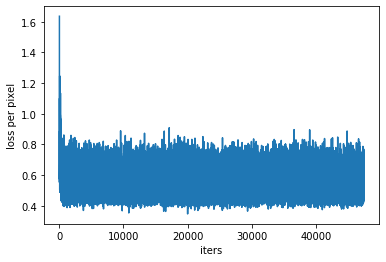

In [38]:
fig = plt.figure()
ax = plt.gca()
ax.plot(total_loss_hist)
ax.set_xlabel('iters')
ax.set_ylabel('loss per pixel')

In [20]:
# save_model_state(
#     model_root=model_root,
#     model_prefix=model_prefix,
#     index=0, save_adam_state=False)

## Exploration

In [39]:
i_dataset_denoising = 0
i_t_begin_denoising = 2000
i_t_end_denoising = 2700
x0_denoising = 0
y0_denoising = 0
x_window_denoising = 512
y_window_denoising = 180

post_eval = False
model_snapshot_stride = 5
model_averaging_begin_index = 400
model_averaging_end_index = i_iter // save_every

In [52]:
# baseline: n-fold spatio temporal NN averaging
n_iters_ma = 1
nnma_denoised_movie_txy = ws_denoising_list[i_dataset_denoising].padded_scaled_diff_movie_1txy[
    0, i_t_begin_denoising:i_t_end_denoising, ...].copy()
for i_iter_ma in range(n_iters_ma):
    prev = nnma_denoised_movie_txy.copy()
    for i_t in range(1, i_t_end_denoising - i_t_begin_denoising - 1):
        nnma_denoised_movie_txy[i_t, 1:-1, 1:-1] = get_nn_spatial_mean(prev, i_t)
nnma_denoised_movie_txy = crop_center(
    nnma_denoised_movie_txy,
    target_width=ws_base_diff_list[0].width,
    target_height=ws_base_diff_list[0].height)

# raw
raw_movie_txy = np.zeros(
    (i_t_end_denoising - i_t_begin_denoising, ws_base_diff_list[0].width, ws_base_diff_list[0].height),
    dtype=np.float32)
for i_t in range(i_t_begin_denoising, i_t_end_denoising):
    raw_movie_txy[i_t - i_t_begin_denoising, ...] = \
        crop_center(
            ws_denoising_list[i_dataset_denoising].padded_scaled_diff_movie_1txy[:, i_t, ...],
            target_width=ws_base_diff_list[0].width,
            target_height=ws_base_diff_list[0].height)

In [53]:
viz_pixels = [(115, 70), (405, 90)]
keep_full_denoised_movies = False

In [54]:
if post_eval:  # load saved models from disk at different iterations

    eval_states = []
    eval_state_labels = []
    for index in range(model_averaging_begin_index, model_averaging_end_index, model_snapshot_stride):
        try:
            eval_states.append(load_model_state(model_root, model_prefix, index))
            eval_state_labels.append(str(index))
        except:
            pass

    eval_states.append(get_swa_state_dict(
        model_root, model_prefix, model_averaging_begin_index, model_averaging_end_index))
    eval_state_labels.append('SWA')

    # generate denoised movies for each state
    init_state = end_to_end_denoiser.state_dict()
    denoised_movie_txy_list = []
    trunc_denoised_movie_pt_list = []
    for state, label in zip(eval_states, eval_state_labels):
        print(f'Generating denoising movie for state {label} ...')
        
        end_to_end_denoiser.load_state_dict(state)
        denoised_movie_txy = generate_denoised_movie(
            ws_denoising_list=ws_denoising_list,
            spatial_unet_processor=spatial_unet_processor,
            temporal_denoiser=temporal_denoiser,
            i_dataset=i_dataset_denoising,
            i_t_begin=i_t_begin_denoising,
            i_t_end=i_t_end_denoising,
            x0=x0_denoising,
            y0=y0_denoising,
            x_window=x_window_denoising,
            y_window=y_window_denoising)
        
        # keep full movie?
        if keep_full_denoised_movies:
            denoised_movie_txy_list.append(denoised_movie_txy)
            
        # only on viz pixels
        trunc_denoised_movie_pt = np.zeros((len(viz_pixels), denoised_movie_txy.shape[0]))
        for i_pixel, (viz_x0, viz_y0) in enumerate(viz_pixels):
            trunc_denoised_movie_pt[i_pixel, :] = denoised_movie_txy[:, viz_x0, viz_y0]
        trunc_denoised_movie_pt_list.append(trunc_denoised_movie_pt)
            
    end_to_end_denoiser.load_state_dict(init_state)

    # SMA movie
    if keep_full_denoised_movies:
        denoised_movie_sma_txy = get_denoised_movie_sma_txy(denoised_movie_txy_list[:-1])
    trunc_denoised_movie_sma_pt = np.mean(trunc_denoised_movie_pt_list[:-1], axis=0)
    
else:
    
    denoised_movie_txy_list = []
    denoised_movie_txy = generate_denoised_movie(
            ws_denoising_list=ws_denoising_list,
            spatial_unet_processor=spatial_unet_processor,
            temporal_denoiser=temporal_denoiser,
            i_dataset=i_dataset_denoising,
            i_t_begin=i_t_begin_denoising,
            i_t_end=i_t_end_denoising,
            x0=x0_denoising,
            y0=y0_denoising,
            x_window=x_window_denoising,
            y_window=y_window_denoising)
    denoised_movie_txy_list.append(denoised_movie_txy)
    eval_state_labels = ['latest']
    denoised_movie_sma_txy = None

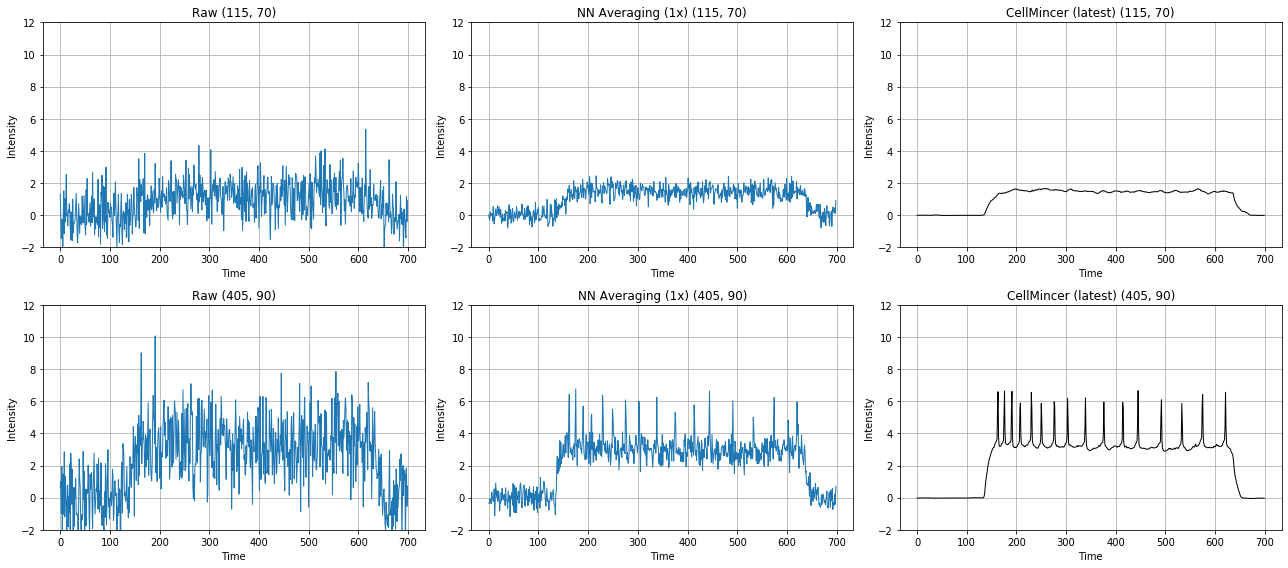

In [57]:
if post_eval:
    ncols = 5
else:
    ncols = 3

fig, axs = plt.subplots(ncols=ncols, nrows=len(viz_pixels), figsize=(6 * ncols, 4 * len(viz_pixels)))

for i_pixel, (viz_x0, viz_y0) in enumerate(viz_pixels):
    
    pixel_str = f' ({viz_x0}, {viz_y0})'
    axs[i_pixel, 0].plot(raw_movie_txy[:, viz_x0, viz_y0], lw=1)
    axs[i_pixel, 0].set_title('Raw' + pixel_str)
    axs[i_pixel, 0].set_xlabel('Time')
    axs[i_pixel, 0].set_ylabel('Intensity')
    axs[i_pixel, 0].grid()

    axs[i_pixel, 1].plot(nnma_denoised_movie_txy[1:, viz_x0, viz_y0], lw=1)
    axs[i_pixel, 1].set_title(f'NN Averaging ({n_iters_ma}x)' + pixel_str)
    axs[i_pixel, 1].set_xlabel('Time')
    axs[i_pixel, 1].set_ylabel('Intensity')
    axs[i_pixel, 1].grid()

    if post_eval:
        
        for trunc_denoised_movie_pt, label in zip(trunc_denoised_movie_pt_list[:-1], eval_state_labels[:-1]):
            axs[i_pixel, 2].plot(trunc_denoised_movie_pt[i_pixel, :], label=label, lw=1, color='black', alpha=0.05)
            axs[i_pixel, 2].set_title('CellMincer (snapshots)' + pixel_str)
            axs[i_pixel, 2].set_xlabel('Time')
            axs[i_pixel, 2].set_ylabel('Intensity')
        axs[i_pixel, 2].grid()

        axs[i_pixel, 3].plot(trunc_denoised_movie_pt_list[-1][i_pixel, :], label=label, lw=1, color='black')
        axs[i_pixel, 3].set_title('CellMincer (SWA)' + pixel_str)
        axs[i_pixel, 3].set_xlabel('Time')
        axs[i_pixel, 3].set_ylabel('Intensity')
        axs[i_pixel, 3].grid()

        axs[i_pixel, 4].plot(trunc_denoised_movie_sma_pt[i_pixel, :], label=label, lw=1, color='black')
        axs[i_pixel, 4].set_title('CellMincer (SMA)' + pixel_str)
        axs[i_pixel, 4].set_xlabel('Time')
        axs[i_pixel, 4].set_ylabel('Intensity')
        axs[i_pixel, 4].grid()
        
    else:
        
        axs[i_pixel, 2].plot(denoised_movie_txy_list[-1][:, viz_x0, viz_y0], lw=1, color='black')
        axs[i_pixel, 2].set_title('CellMincer (latest)' + pixel_str)
        axs[i_pixel, 2].set_xlabel('Time')
        axs[i_pixel, 2].set_ylabel('Intensity')
        axs[i_pixel, 2].grid()

ylim_list = [(-2, 12), (-2, 12)]
for i_pixel in range(len(viz_pixels)):
    for i_col in range(ncols):
        axs[i_pixel, i_col].set_ylim(ylim_list[i_pixel])

# # lock y limits for each viz pixel
# for i_pixel in range(len(viz_pixels)):
#     min_y_lim = np.inf
#     max_y_lim = -np.inf
#     for i_col in range(ncols):
#         ylim = axs[i_pixel, i_col].get_ylim()
#         min_y_lim = min(min_y_lim, ylim[0])
#         max_y_lim = max(max_y_lim, ylim[1])
#     for i_col in range(ncols):
#         axs[i_pixel, i_col].set_ylim((min_y_lim, max_y_lim))

plt.tight_layout()
# plt.savefig(f'./out/{opto_mov_prefixes[i_dataset_denoising]}_{model_prefix}.pdf')

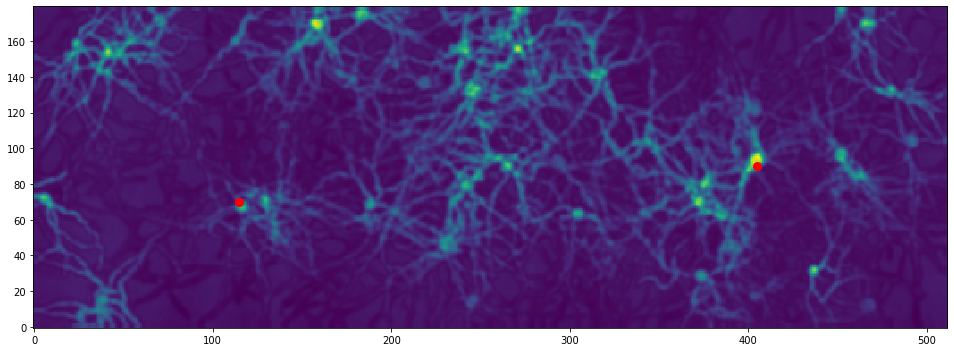

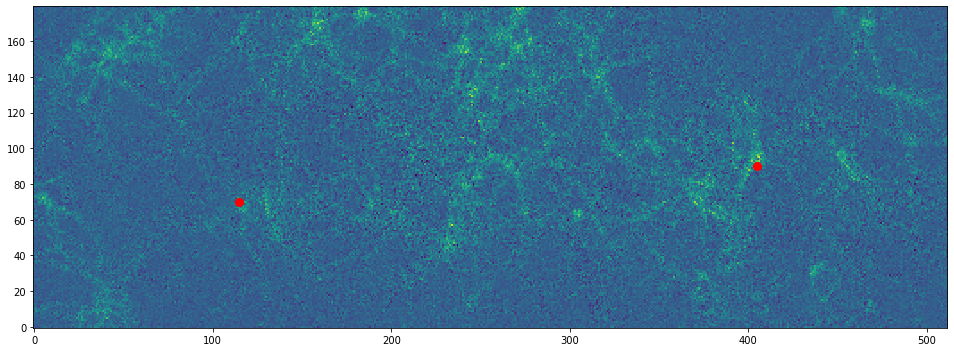

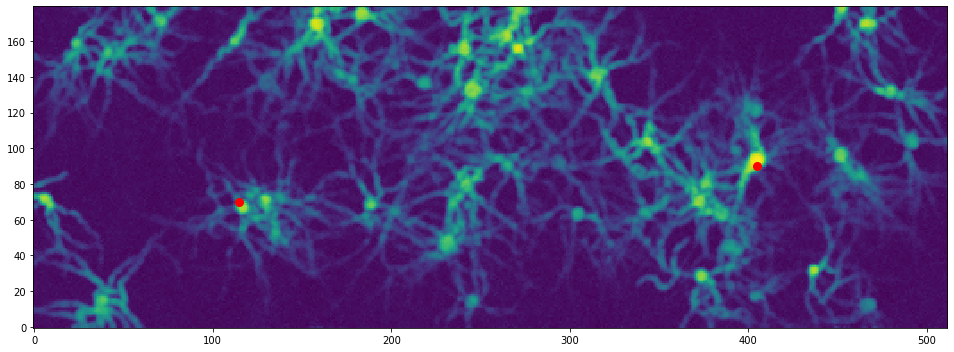

In [56]:
viz_i_t = 350

fig, ax = new_fig()
im = ax.imshow(denoised_movie_txy[viz_i_t, ...].T, origin='lower')
for (viz_x0, viz_y0) in viz_pixels:
    ax.plot([viz_x0], [viz_y0], marker='.', markersize=16, color='red')
plt.tight_layout()
# plt.savefig(f'./out/{opto_mov_prefixes[i_dataset_denoising]}_{model_prefix}_denoised_snapshot.pdf')

fig, ax = new_fig()
im = ax.imshow(raw_movie_txy[viz_i_t, ...].T, origin='lower')
for (viz_x0, viz_y0) in viz_pixels:
    ax.plot([viz_x0], [viz_y0], marker='.', markersize=16, color='red')
plt.tight_layout()
# plt.savefig(f'./out/{opto_mov_prefixes[i_dataset_denoising]}_{model_prefix}_raw_snapshot.pdf')

fig, ax = new_fig()
im = ax.imshow(ws_base_diff_list[i_dataset_denoising].movie_t_corr_xy.T, origin='lower')
for (viz_x0, viz_y0) in viz_pixels:
    ax.plot([viz_x0], [viz_y0], marker='.', markersize=16, color='red')
plt.tight_layout()
# plt.savefig(f'./out/{opto_mov_prefixes[i_dataset_denoising]}_{model_prefix}_corr.pdf')

## Visualize the learning dynamics

(deprecated)

In [ ]:
%matplotlib inline

import matplotlib.animation as animation
import time as time

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
i_pixel = 0

def update_frame(snapshot_index):
    snapshot_i_iter = (model_averaging_begin_index + model_snapshot_stride * snapshot_index) * save_every
    axs[0].clear()
    axs[0].scatter(np.arange(len(total_loss_hist)), total_loss_hist, s=1, alpha=0.5)
    axs[0].plot([snapshot_i_iter, snapshot_i_iter], [0.5, 0.8], lw=2, color='red')
    axs[1].clear()
    axs[1].plot(trunc_denoised_movie_pt_list[snapshot_index][i_pixel, :], lw=1, color='black')
    
    axs[0].set_ylim((0.5, 0.8))
    axs[0].set_xlim((0, len(total_loss_hist)))
    axs[0].set_ylabel('Loss (per pixel)', fontsize=16)
    axs[0].set_xlabel('Iteration', fontsize=16)

    axs[1].set_ylim((-0.5, 10.))
    axs[1].set_xlim((0, 600))
    axs[1].set_ylabel('Denoised intensity', fontsize=16)
    axs[1].set_xlabel('Time', fontsize=16)

    fig.tight_layout()


update_frame(0)
ani = animation.FuncAnimation(fig, update_frame, len(trunc_denoised_movie_pt_list))
writer = animation.writers['ffmpeg'](fps=30)
ani.save('demo.mp4', writer=writer, dpi=100)

## Generate denoised datasets

In [58]:
from time import time

for i_dataset in range(n_datasets):

    t_mid = (denoiser_config['t_order'] - 1) // 2
    denoised_movie_txy = np.zeros_like(ws_base_diff_list[i_dataset].movie_txy)
    log_frequency = 500
    total_frames = ws_base_diff_list[i_dataset].n_frames - t_mid
    t0 = time()

    for i_t in range(t_mid, total_frames):

        denoising_input_data = generate_input_for_single_frame_denoising(
            ws_denoising_list=ws_denoising_list,
            i_dataset=i_dataset,
            i_t=i_t,
            t_order=denoiser_config['t_order'],
            x0=0,
            y0=0,
            x_window=ws_base_diff_list[i_dataset].width,
            y_window=ws_base_diff_list[i_dataset].height,
            device=device,
            dtype=dtype)

        denoised_frame_xy = denoise_single_frame(
            denoising_input_data,
            ws_denoising_list=ws_denoising_list,
            spatial_unet_processor=spatial_unet_processor,
            temporal_denoiser=temporal_denoiser)['temporal_endpoint_xy']

        denoised_movie_txy[i_t, ...] = denoised_frame_xy.cpu().numpy()

        if (i_t - t_mid) % log_frequency == 0 and i_t > t_mid:
            fps = log_frequency / (time() - t0)
            t0 = time()
            print(f'[{opto_mov_prefixes[i_dataset]}] processed {i_t - t_mid}/{total_frames} frames ({fps:.3} fps)...')

    denoised_movie_txy[:t_mid, ...] = denoised_movie_txy[t_mid, ...]
    denoised_movie_txy[total_frames:, ...] = denoised_movie_txy[total_frames - 1, ...]

    np.save(
        os.path.join(
            output_path,
            opto_mov_prefixes[i_dataset] + "__" + model_prefix + "__denoised.npy"),
        denoised_movie_txy.transpose(0, 2, 1))

[optosynth_test_movie] processed 500/6994 frames (8.72 fps)...
[optosynth_test_movie] processed 1000/6994 frames (8.74 fps)...
[optosynth_test_movie] processed 1500/6994 frames (8.73 fps)...
[optosynth_test_movie] processed 2000/6994 frames (8.73 fps)...
[optosynth_test_movie] processed 2500/6994 frames (8.73 fps)...
[optosynth_test_movie] processed 3000/6994 frames (8.73 fps)...
[optosynth_test_movie] processed 3500/6994 frames (8.73 fps)...
[optosynth_test_movie] processed 4000/6994 frames (8.73 fps)...
[optosynth_test_movie] processed 4500/6994 frames (8.73 fps)...
[optosynth_test_movie] processed 5000/6994 frames (8.73 fps)...
[optosynth_test_movie] processed 5500/6994 frames (8.73 fps)...
[optosynth_test_movie] processed 6000/6994 frames (8.73 fps)...
[optosynth_test_movie] processed 6500/6994 frames (8.73 fps)...


## Make movies

In [17]:
import skvideo
from skvideo import io as skio
from matplotlib.colors import Normalize

In [65]:
for i_dataset in range(n_datasets):
    # write denoised movie
    denoised_movie_txy = np.load(
        os.path.join(
            output_path,
            opto_mov_prefixes[i_dataset] + "__" + model_prefix + "__denoised.npy")).transpose(0, 2, 1)

    lo = np.min(denoised_movie_txy)
    hi = np.max(denoised_movie_txy)
    norm = Normalize(
        vmin=lo,
        vmax=hi - 0.1 * (hi - lo),
        clip=True)
    denoised_movie_txy = (255 * norm(denoised_movie_txy)[..., None])

    movie_out_path = os.path.join(
        output_path,
        opto_mov_prefixes[i_dataset] + "__" + model_prefix + "__denoised.avi")

    writer = skio.FFmpegWriter(
        movie_out_path,
        outputdict={'-vcodec': 'rawvideo', '-pix_fmt': 'yuv420p', '-r': '60'})

    for i in range(0, 7000):
            writer.writeFrame(denoised_movie_txy[i, ...].T)
    writer.close()

In [18]:
# write raw movie
movie_out_path = os.path.join(
    output_path,
    opto_mov_prefixes[i_dataset] + '_raw.avi')

writer = skvideo.io.FFmpegWriter(
    movie_out_path,
    outputdict={'-vcodec': 'rawvideo', '-pix_fmt': 'yuv420p', '-r': '60'})

lo = np.min(ws_base_diff_list[i_dataset].movie_txy)
hi = np.max(ws_base_diff_list[i_dataset].movie_txy)
norm = Normalize(
    vmin=0,
    vmax=hi - 0.1 * (hi - lo),
    clip=True)
raw_diff_movie_txy = (255 * norm(ws_base_diff_list[i_dataset].movie_txy)[..., None])

for i in range(0, 7000):
        writer.writeFrame(raw_diff_movie_txy[i, ...].T)
writer.close()

In [22]:
clean_movie_txy = np.load(
    '/home/jupyter/mb-ml-data/Optosynth_output/test_data/clean_movie_tyx.npy').transpose((0, 2, 1))
bg_movie_txy = np.load(
    '/home/jupyter/mb-ml-data/Optosynth_output/test_data_proc/test_data_trend.npy')
diff_movie_clean_txy = (clean_movie_txy - bg_movie_txy) / feature_container_list[0].norm_scale

In [23]:
# write clean movie
movie_out_path = os.path.join(
    output_path,
    opto_mov_prefixes[i_dataset] + '_clean.avi')

writer = skvideo.io.FFmpegWriter(
    movie_out_path,
    outputdict={'-vcodec': 'rawvideo', '-pix_fmt': 'yuv420p', '-r': '60'})

lo = np.min(diff_movie_clean_txy)
hi = np.max(diff_movie_clean_txy)
norm = Normalize(
    vmin=lo,
    vmax=hi - 0.1 * (hi - lo),
    clip=True)
diff_movie_clean_txy = (255 * norm(diff_movie_clean_txy)[..., None])

for i in range(0, 7000):
        writer.writeFrame(diff_movie_clean_txy[i, ...].T)
writer.close()